## Homework Week 6

In [63]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import xgboost as xgb

In [37]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"

In [38]:
!wget $url -O data.csv 

--2023-10-18 00:51:49--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.36M  6.78MB/s    in 0.2s    

2023-10-18 00:51:49 (6.78 MB/s) - ‘data.csv’ saved [1423529/1423529]



In [39]:
df_full = pd.read_csv('data.csv')
df_full.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [40]:
df = df_full
df = df[(df['ocean_proximity'] == '<1H OCEAN') | (df['ocean_proximity'] == 'INLAND')]
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,<1H OCEAN
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,<1H OCEAN
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,<1H OCEAN


In [41]:
df = df.fillna(0)

In [42]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

len(df_train), len(df_val), len(df_test)

(9411, 3138, 3138)

In [43]:
cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "ocean_proximity"]

dv = DictVectorizer(sparse=True)

train_dict = df_train[cols].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[cols].to_dict(orient='records')
X_val = dv.transform(val_dict)

## Question 1

In [58]:
dt = DecisionTreeRegressor(max_depth=1)

dt.fit(X_train, y_train)

print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



**Answer = ocean_proximity**

## Question 2

In [53]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
np.round(np.sqrt(mean_squared_error(y_val, y_pred)),3)

0.245

**Answer = 0.245**

## Question 3

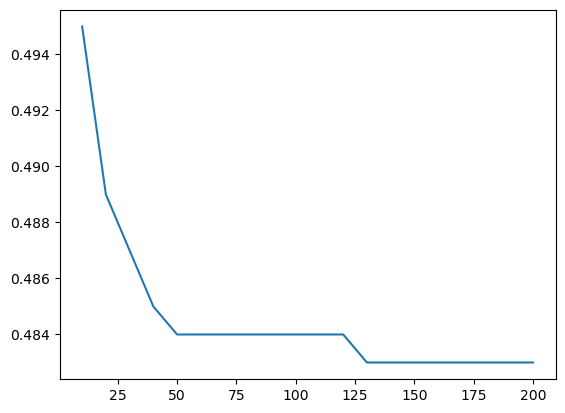

In [94]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = np.round(np.sqrt(mean_squared_error(y_val, y_pred, squared=False)),3)
    
    scores.append((n, rmse))
    
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.show()

**Answer = 50**

## Question 4

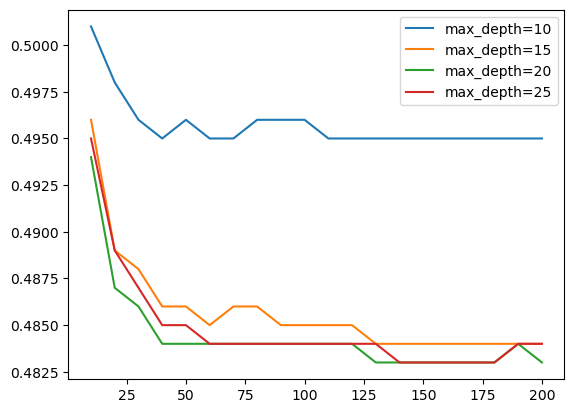

In [93]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1,
                                    n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = np.round(np.sqrt(mean_squared_error(y_val, y_pred, squared=False)),3)
        scores.append((d, n, rmse))
    
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'rmse'])

for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

**Answer = 25**

## Question 5

In [60]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=1)
rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_

df_feature = pd.DataFrame(feature_importances, list(dv.get_feature_names_out()))
df_feature

,0
households,0.015527
housing_median_age,0.030003
latitude,0.101855
longitude,0.086367
median_income,0.335563
ocean_proximity=<1H OCEAN,0.292473
ocean_proximity=INLAND,0.073806
population,0.027353
total_bedrooms,0.015328
total_rooms,0.021723


**Answer = median_income**

## Question 6

In [84]:
features = list(dv.get_feature_names_out())

features = [i.replace("=<", "_").replace("=","_") for i in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'val')]

scores = {}

In [85]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train', 'val']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [86]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [87]:
scores['eta=0.3'] = parse_xgb_output(output)

In [88]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [89]:
scores['eta=0.1'] = parse_xgb_output(output)

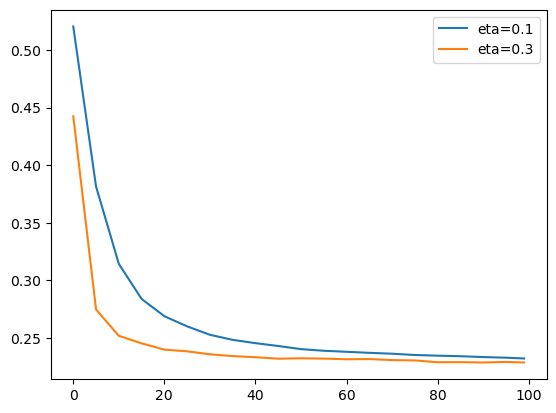

In [91]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val,
        label='eta=0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val,
        label='eta=0.3')
plt.legend()
plt.show()

**Answer = 0.3**